In [1]:
%%capture --no-stderr
# %pip install -U langgraph langchain_community langchain_openai langchain_experimental langchain-chroma pypdf sentence-transformers

In [2]:
import os

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = "" #put your langchain api key here
# os.environ["LANGCHAIN_PROJECT"] = "langgraph_multi_agent_blog"

### Setup API Keys

In [9]:
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [10]:
_set_env("TAVILY_API_KEY")

In [11]:
_set_env("OPENAI_API_KEY")

### Creating LLM

In [12]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o")

In [13]:
# Test llm 
llm.invoke("what is capital of India")

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 12, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-65b2d52d-115e-4bb7-945e-a9c0730f84a6-0', usage_metadata={'input_tokens': 12, 'output_tokens': 9, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### Websearch Tool

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=2)

### RAG tool

In [15]:
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List
from langchain_core.documents import Document
import os

def load_documents(folder_path: str) -> List[Document]:
    documents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        print(file_path)
        if filename.endswith('.pdf'):
            loader = PyPDFLoader(file_path)
        elif filename.endswith('.docx'):
            loader = Docx2txtLoader(file_path)
        else:
            print(f"Unsupported file type: {filename}")
            continue
        documents.extend(loader.load())
    return documents

folder_path = "./docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

./docs/Bain-2023 US Benefit Guide Candidates.pdf
Loaded 29 documents from the folder.


In [16]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

splits = text_splitter.split_documents(documents)
print(f"Split the documents into {len(splits)} chunks.")

Split the documents into 40 chunks.


In [17]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

from langchain_chroma import Chroma

collection_name = "my_collection"
vectorstore = Chroma.from_documents(
    collection_name=collection_name,
    documents=splits,
    embedding=embedding_function,
    persist_directory="./chroma_db"
)
print("Vector store created and persisted to './chroma_db'")

/var/folders/rp/qhg82jr94n9db0b3t83pkpbj2ty1x0/T/ipykernel_42269/694609584.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


Vector store created and persisted to './chroma_db'


In [18]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("Does Bain provide Tuition Support?")
print(retriever_results)

[Document(id='a54555b1-b47c-44f0-8d66-a529577b6fac', metadata={'page': 25, 'page_label': '26', 'source': './docs/Bain-2023 US Benefit Guide Candidates.pdf'}, page_content='Tuition Program\n• To assist you in your pursuit of higher education, Bain & Company will subsidize business \nschool tuition for eligible consulting staff who receive an offer of promotion to Consultant \nafter completing business school\n• Bain also offers a Business Skills Training Program for eligible functional professionals, expert \nclient delivery professionals and Engine 2 professionals\n• Support is available toward a first college degree, up to an annual maximum of $5,250, or \nfor a job-related course for a second degree or a non-degree university course, up to an \nannual maximum of $10,000\n• The lifetime maximum for both programs is $30,000'), Document(id='c192e3b8-1202-4d1b-898e-dad531d8b106', metadata={'page': 25, 'page_label': '26', 'source': './docs/Bain-2023 US Benefit Guide Candidates.pdf'}, page

In [19]:
from langchain.tools import tool
from pydantic import BaseModel

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def retriever_tool(question):
  """Tool to Retrieve Semantically Similar documents to answer User Questions related to Bain & Company benefits for their employees"""
  print("INSIDE RETRIEVER NODE")
  retriever = vectorstore.as_retriever(search_kwargs={"k": 2})
  retriever_result = retriever.invoke(question)
  return "\n\n".join(doc.page_content for doc in retriever_results)

### NL2SQL Tool

In [14]:
# !wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

In [15]:
# !mv Chinook_Sqlite.sqlite Chinook.db

In [20]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [21]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text

In [22]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_tool(question):
  """Tool to Generate and Execute SQL Query to answer User Questions related to Chinook DB which is about Music Store which has Albums, Artists etc."""
  print("INSIDE NL2SQL TOOL")
  execute_query = QuerySQLDataBaseTool(db=db)
  write_query = create_sql_query_chain(llm, db)

  chain = (
      RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
          result=itemgetter("query") | execute_query
      )
  )

  response = chain.invoke({"question": question})
  return response['result']

question = "How many albums are sold in Chinook music store?"
result = nl2sql_tool.invoke({"question": question})
print(f"Question: {question}")
print(f"Answer: {result}")

INSIDE NL2SQL TOOL


/var/folders/rp/qhg82jr94n9db0b3t83pkpbj2ty1x0/T/ipykernel_42269/1340306113.py:16: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query = QuerySQLDataBaseTool(db=db)


Question: How many albums are sold in Chinook music store?
Answer: [(304,)]


In [23]:
question = "display schema"
result = nl2sql_tool.invoke({"question": question})
print(f"Question: {question}")
print(f"Answer: {result}")

INSIDE NL2SQL TOOL
Question: display schema
Answer: Error: (sqlite3.OperationalError) near "To": syntax error
[SQL: To display the schema of a SQLite database, you can use the SQLite command .schema. However, since this type of query is typically run in a command-line interface or SQLite tool rather than via SQL directly in a query command, it's unclear what exactly you're requesting. If what you mean by "display schema" is to see descriptions to understand table structures in the context of a SQL query format, here's a direct response based on the provided schema: -- Schema for Album table CREATE TABLE "Album" ( "AlbumId" INTEGER NOT NULL, "Title" NVARCHAR(160) NOT NULL, "ArtistId" INTEGER NOT NULL, PRIMARY KEY ("AlbumId"), FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId") ); -- Schema for Artist table CREATE TABLE "Artist" ( "ArtistId" INTEGER NOT NULL, "Name" NVARCHAR(120), PRIMARY KEY ("ArtistId") ); -- Schema for Customer table CREATE TABLE "Customer" ( "CustomerId" INTEGER

### Create Supervisor Agent

In [24]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command


#agents
members = ["web_researcher", "rag", "nl2sql"]
# Our supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["web_researcher", "rag", "nl2sql","FINISH"]


def supervisor_node(state: MessagesState) -> Command[Literal["web_researcher", "rag", "nl2sql", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

### Create Web Research, RAG and NL2SQL Agent

In [25]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [26]:
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast
from langchain_core.language_models import BaseChatModel, LanguageModelLike
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langchain_core.runnables import (
    Runnable,
    RunnableBinding,
    RunnableConfig,
)
from langchain_core.tools import BaseTool
from typing_extensions import Annotated, TypedDict
from langgraph._api.deprecation import deprecated_parameter
from langgraph.errors import ErrorCode, create_error_message
from langgraph.graph import StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep, RemainingSteps
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.store.base import BaseStore
from langgraph.types import Checkpointer
from langgraph.utils.runnable import RunnableCallable

class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]

def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
      return {"messages": [llm_with_tools.invoke(state["messages"])]}
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    # Any time a tool is called, we return to the chatbot to decide the next step
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    graph = graph_builder.compile()
    return graph

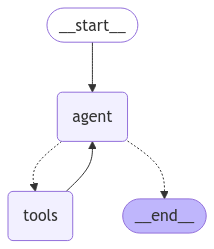

In [27]:
websearch_agent = create_agent(llm, [web_search_tool])

from IPython.display import Image, display

try:
    display(Image(websearch_agent.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [28]:
def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_researcher")
            ]
        },
        goto="supervisor",
    )

In [29]:
result = websearch_agent.invoke({"messages": [("user", "what is the weather in New Delhi today?")]})

In [30]:
result['messages'][-1].content

'The weather in New Delhi today, October 14, 2023, is expected to reach a high of 91°F (about 33°C) during the day and drop to 72°F (about 22°C) at night. Currently, there is misty weather with a temperature of 16.4°C (61.5°F). The wind is blowing from the west at 6.8 kph (4.3 mph), and the humidity level is at 88%. Visibility is about 1.9 km (1 mile).'

In [31]:
rag_agent = create_agent(llm, [retriever_tool])

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag")
            ]
        },
        goto="supervisor",
    )

In [32]:
nl2sql_agent = create_agent(llm, [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )

In [33]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)
builder.add_node("nl2sql", nl2sql_node)
graph = builder.compile()

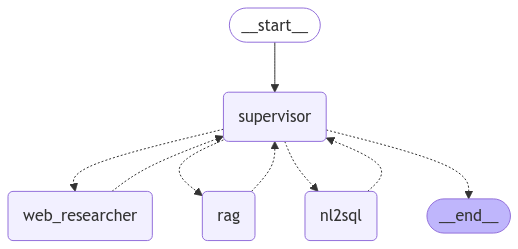

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass

In [57]:
# Example Usecase: NL2SQL(*) -> Web Search
for s in graph.stream(
    {"messages": [("user", "In Chinook DB, Which is the most sold album? Give me a Bio of the Artist of that Album")]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: nl2sql
((), {'supervisor': None})
----
INSIDE NL2SQL TOOLINSIDE NL2SQL TOOL

(('nl2sql:d1af746d-86fb-9470-96d8-a62ee2d4dfce',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9GRUKMIt2xpLHlhtr8k4GoRu', 'function': {'arguments': '{"question": "Which is the most sold album in Chinook DB?"}', 'name': 'nl2sql_tool'}, 'type': 'function'}, {'id': 'call_w0G4M43zsuX2iBTNz1Ck08KM', 'function': {'arguments': '{"question": "Provide a bio of the artist of the most sold album in Chinook DB."}', 'name': 'nl2sql_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 89, 'total_tokens': 163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_

In [59]:
# Example Usecase: Web Search(*) -> RAG
input_question = "Does Bain & Company provide Healthcare benefits ? Does Mckinsey provide it as well?"

for s in graph.stream(
    {"messages": [("user", input_question)]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:6b5957bc-8913-8a7c-941b-636e0a7dec90',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PIdWG0ffsYPVabE1gCjHywHZ', 'function': {'arguments': '{"query": "Bain & Company healthcare benefits 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_r2lupbmU062G7WIS0f34oOj6', 'function': {'arguments': '{"query": "McKinsey healthcare benefits 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 97, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs':

In [61]:
# Example Usecase: Web Search -> RAG -> NL2SQL
input_question = "I have a fascinating research question about digital transformation in consulting. Could you first check what digital tools and subscriptions Bain provides to their employees? Then, analyze the Chinook database to show how digital music sales transformed the industry's revenue patterns. Finally, find recent research about how consulting firms are adapting to digital transformation."

for s in graph.stream(
    {"messages": [("user", input_question)]}, subgraphs=True
):
    print(s)
    print("----")

Next Worker: web_researcher
((), {'supervisor': None})
----
(('web_researcher:1642fb3e-56c3-d46c-439b-a80972732396',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MhfQzQay1IpClAuSJ2CsBpUm', 'function': {'arguments': '{"query": "digital tools and subscriptions Bain provides to employees"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_xIffJG8Kr9R3l8VkCefMQmAK', 'function': {'arguments': '{"query": "consulting firms adapting to digital transformation research 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 140, 'total_tokens': 210, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_469